In [1]:
import os
import numpy as np
import cv2
import torch
import torch.nn.functional as F
from skimage import io
import torch.nn as nn
import torch.nn.init as init
import torchvision
from torchvision import models
import matplotlib.pyplot as plt
from collections import namedtuple
from packaging import version
from collections import OrderedDict

In [36]:
m_name = "sample_manuscript" #document name
start_page = 1
end_page = 2 

if m_name == "sample_manuscript":
  manuscript_id = 3976 # if every page in the manuscript has a prefix

device = torch.device('cuda') #change to cpu if no gpu

In [37]:
# Function Definitions
def loadImage(img_file):
    img = io.imread(img_file)           # RGB order
    if img.shape[0] == 2: img = img[0]
    if len(img.shape) == 2 : img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    if img.shape[2] == 4:   img = img[:,:,:3]
    img = np.array(img)

    return img

def normalizeMeanVariance(in_img, mean=(0.485, 0.456, 0.406), variance=(0.229, 0.224, 0.225)):
    # should be RGB order
    img = in_img.copy().astype(np.float32)

    img -= np.array([mean[0] * 255.0, mean[1] * 255.0, mean[2] * 255.0], dtype=np.float32)
    img /= np.array([variance[0] * 255.0, variance[1] * 255.0, variance[2] * 255.0], dtype=np.float32)
    return img


def init_weights(modules):
    for m in modules:
        if isinstance(m, nn.Conv2d):
            init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()

class vgg16_bn(torch.nn.Module):
    def __init__(self, pretrained=True, freeze=True):
        super(vgg16_bn, self).__init__()
        if version.parse(torchvision.__version__) >= version.parse('0.13'):
            vgg_pretrained_features = models.vgg16_bn(
                weights=models.VGG16_BN_Weights.DEFAULT if pretrained else None
            ).features
        else: #torchvision.__version__ < 0.13
            models.vgg.model_urls['vgg16_bn'] = models.vgg.model_urls['vgg16_bn'].replace('https://', 'http://')
            vgg_pretrained_features = models.vgg16_bn(pretrained=pretrained).features

        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        for x in range(12):         # conv2_2
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(12, 19):         # conv3_3
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(19, 29):         # conv4_3
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(29, 39):         # conv5_3
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
            
        # fc6, fc7 without atrous conv
        self.slice5 = torch.nn.Sequential(
                nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6),
                nn.Conv2d(1024, 1024, kernel_size=1)
        )

        if not pretrained:
            init_weights(self.slice1.modules())
            init_weights(self.slice2.modules())
            init_weights(self.slice3.modules())
            init_weights(self.slice4.modules())

        init_weights(self.slice5.modules())        # no pretrained model for fc6 and fc7

        if freeze:
            for param in self.slice1.parameters():      # only first conv
                param.requires_grad= False

    def forward(self, X):
        h = self.slice1(X)
        h_relu2_2 = h
        h = self.slice2(h)
        h_relu3_2 = h
        h = self.slice3(h)
        h_relu4_3 = h
        h = self.slice4(h)
        h_relu5_3 = h
        h = self.slice5(h)
        h_fc7 = h
        vgg_outputs = namedtuple("VggOutputs", ['fc7', 'relu5_3', 'relu4_3', 'relu3_2', 'relu2_2'])
        out = vgg_outputs(h_fc7, h_relu5_3, h_relu4_3, h_relu3_2, h_relu2_2)
        return out

class BidirectionalLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size * 2, output_size)

    def forward(self, input):
        """
        input : visual feature [batch_size x T x input_size]
        output : contextual feature [batch_size x T x output_size]
        """
        try: # multi gpu needs this
            self.rnn.flatten_parameters()
        except: # quantization doesn't work with this
            pass
        recurrent, _ = self.rnn(input)  # batch_size x T x input_size -> batch_size x T x (2*hidden_size)
        output = self.linear(recurrent)  # batch_size x T x output_size
        return output

class VGG_FeatureExtractor(nn.Module):

    def __init__(self, input_channel, output_channel=256):
        super(VGG_FeatureExtractor, self).__init__()
        self.output_channel = [int(output_channel / 8), int(output_channel / 4),
                               int(output_channel / 2), output_channel]
        self.ConvNet = nn.Sequential(
            nn.Conv2d(input_channel, self.output_channel[0], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(self.output_channel[0], self.output_channel[1], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(self.output_channel[1], self.output_channel[2], 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(self.output_channel[2], self.output_channel[2], 3, 1, 1), nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(self.output_channel[2], self.output_channel[3], 3, 1, 1, bias=False),
            nn.BatchNorm2d(self.output_channel[3]), nn.ReLU(True),
            nn.Conv2d(self.output_channel[3], self.output_channel[3], 3, 1, 1, bias=False),
            nn.BatchNorm2d(self.output_channel[3]), nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(self.output_channel[3], self.output_channel[3], 2, 1, 0), nn.ReLU(True))

    def forward(self, input):
        return self.ConvNet(input)



class Model(nn.Module):

    def __init__(self, input_channel, output_channel, hidden_size, num_class):
        super(Model, self).__init__()
        """ FeatureExtraction """
        self.FeatureExtraction = VGG_FeatureExtractor(input_channel, output_channel)
        self.FeatureExtraction_output = output_channel
        self.AdaptiveAvgPool = nn.AdaptiveAvgPool2d((None, 1))

        """ Sequence modeling"""
        self.SequenceModeling = nn.Sequential(
            BidirectionalLSTM(self.FeatureExtraction_output, hidden_size, hidden_size),
            BidirectionalLSTM(hidden_size, hidden_size, hidden_size))
        self.SequenceModeling_output = hidden_size

        """ Prediction """
        self.Prediction = nn.Linear(self.SequenceModeling_output, num_class)


    def forward(self, input, text):
        """ Feature extraction stage """
        visual_feature = self.FeatureExtraction(input)
        visual_feature = self.AdaptiveAvgPool(visual_feature.permute(0, 3, 1, 2))
        visual_feature = visual_feature.squeeze(3)

        """ Sequence modeling stage """
        contextual_feature = self.SequenceModeling(visual_feature)

        """ Prediction stage """
        prediction = self.Prediction(contextual_feature.contiguous())

        return prediction

"""### CRAFT Model"""

#CRAFT

class double_conv(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch + mid_ch, mid_ch, kernel_size=1),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class CRAFT(nn.Module):
    def __init__(self, pretrained=False, freeze=False):
        super(CRAFT, self).__init__()

        """ Base network """
        self.basenet = vgg16_bn(pretrained, freeze)

        """ U network """
        self.upconv1 = double_conv(1024, 512, 256)
        self.upconv2 = double_conv(512, 256, 128)
        self.upconv3 = double_conv(256, 128, 64)
        self.upconv4 = double_conv(128, 64, 32)

        num_class = 2
        self.conv_cls = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=1), nn.ReLU(inplace=True),
            nn.Conv2d(16, num_class, kernel_size=1),
        )

        init_weights(self.upconv1.modules())
        init_weights(self.upconv2.modules())
        init_weights(self.upconv3.modules())
        init_weights(self.upconv4.modules())
        init_weights(self.conv_cls.modules())

    def forward(self, x):
        """ Base network """
        sources = self.basenet(x)

        """ U network """
        y = torch.cat([sources[0], sources[1]], dim=1)
        y = self.upconv1(y)

        y = F.interpolate(y, size=sources[2].size()[2:], mode='bilinear', align_corners=False)
        y = torch.cat([y, sources[2]], dim=1)
        y = self.upconv2(y)

        y = F.interpolate(y, size=sources[3].size()[2:], mode='bilinear', align_corners=False)
        y = torch.cat([y, sources[3]], dim=1)
        y = self.upconv3(y)

        y = F.interpolate(y, size=sources[4].size()[2:], mode='bilinear', align_corners=False)
        y = torch.cat([y, sources[4]], dim=1)
        feature = self.upconv4(y)

        y = self.conv_cls(feature)

        return y.permute(0,2,3,1), feature

def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict


def detect(img, detector, device):


        x = [np.transpose(normalizeMeanVariance(img), (2, 0, 1))]
        x = torch.from_numpy(np.array(x))
        x = x.to(device)
        with torch.no_grad():
            y, feature = detector(x)
        d = y[0,:,:,0].cpu().data.numpy()
        return d




In [38]:
inp_images=[]
file_names = []
out_images=[]

for i in range(start_page,end_page+1):
  try:
    image = loadImage(f'./input_images/{m_name}/{manuscript_id}_{i:04d}.png')
    file_names.append(f'{manuscript_id}_{i:04d}.png')
  except:
    image = loadImage(f'./input_images/{m_name}/{manuscript_id}_{i:04d}.jpg')
    file_names.append(f'{manuscript_id}_{i:04d}.jpg')

  inp_images.append(image)

_detector = CRAFT()

_detector.load_state_dict(copyStateDict(torch.load("./pretrained_craft/craft_mlt_25k.pth",map_location=device)))

detector = torch.nn.DataParallel(_detector).to(device)

detector.eval()
import time
st = time.time()

for image in inp_images:
  tmp = detect(image,detector, device)
  out_images.append(np.copy(tmp))

#Save heatmaps
if os.path.exists(f'./output_images/{m_name}/heatmaps') == False:
  os.makedirs(f'./output_images/{m_name}/heatmaps')
for _img,_filename in zip(out_images,file_names):
    cv2.imwrite(f'./output_images/{m_name}/heatmaps/{_filename}',255*_img)

print(f"{time.time()-st:.2f} seconds elapsed.....")


0.60 seconds elapsed.....


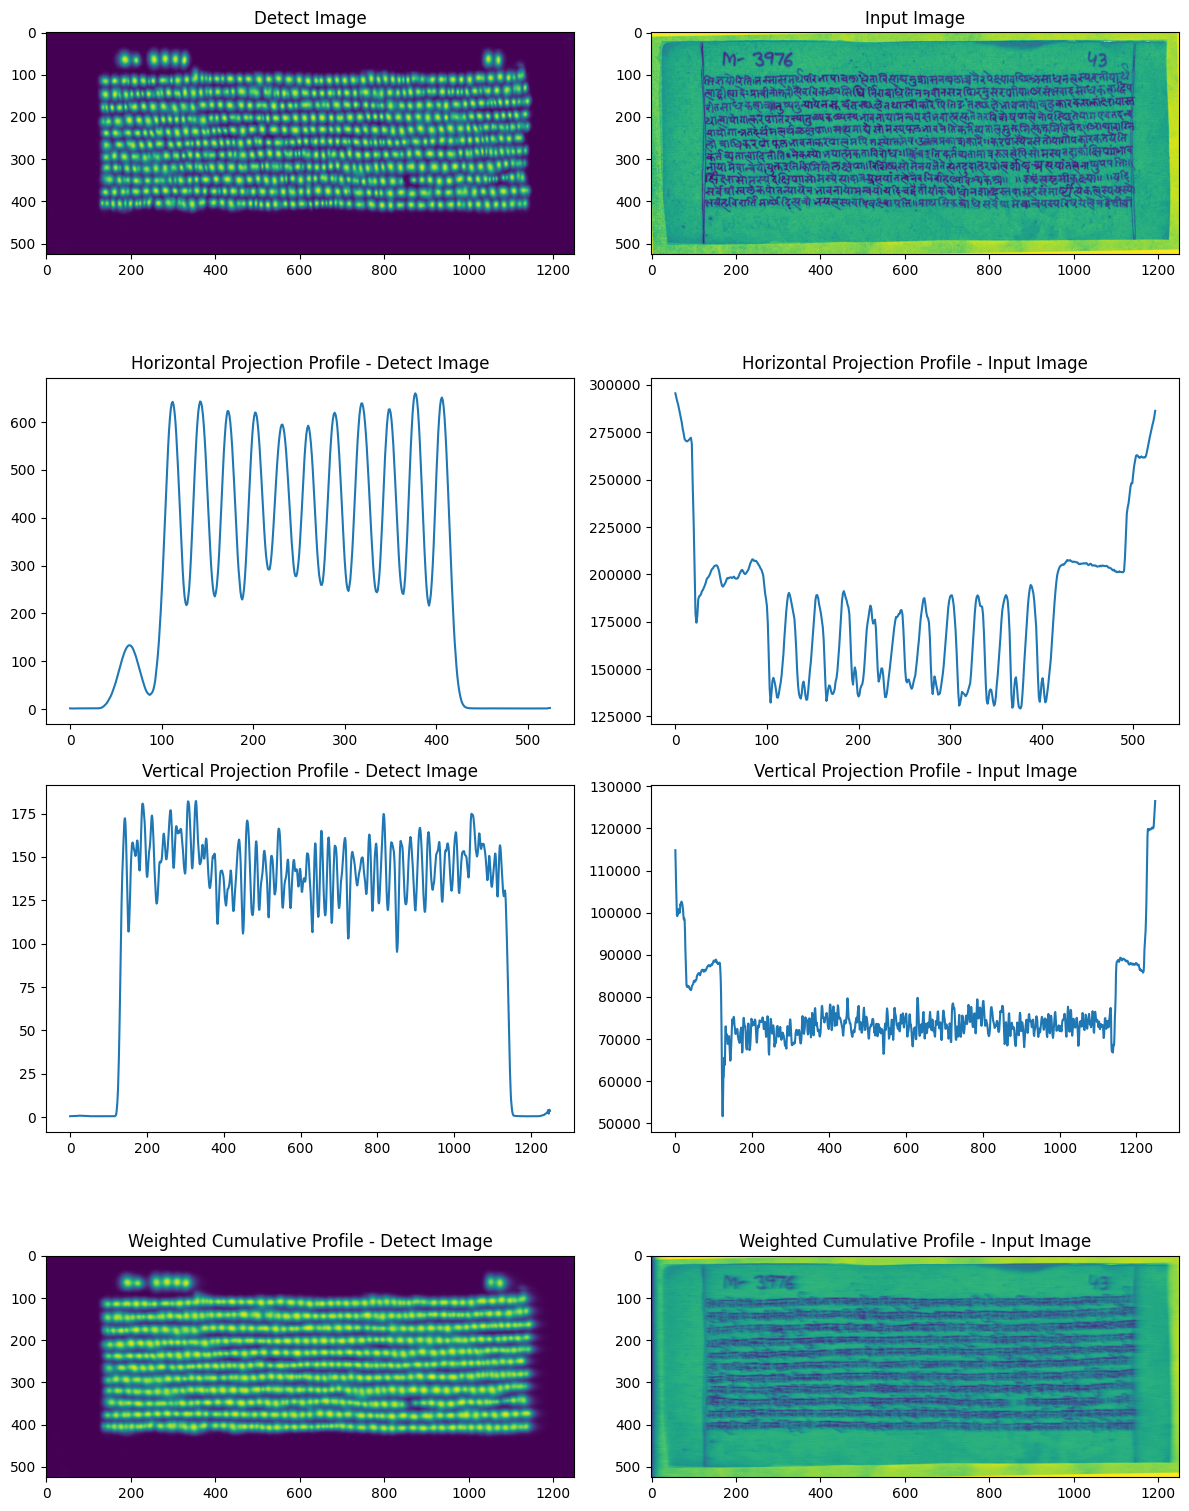

In [39]:
# Visualization - why its easier to do projection profile post CRAFT
def weighted_cumsum(arr, alpha=0.9):
    if arr.ndim == 2:  # Grayscale image
        result = np.zeros_like(arr, dtype=float)
        momentum = np.zeros(arr.shape[0])
        for i in range(arr.shape[1]):
            momentum = alpha * momentum + (1 - alpha) * arr[:, i]
            result[:, i] = momentum
    elif arr.ndim == 3:  # Color image
        result = np.zeros_like(arr, dtype=float)
        momentum = np.zeros((arr.shape[0], arr.shape[2]))
        for i in range(arr.shape[1]):
            momentum = alpha * momentum + (1 - alpha) * arr[:, i, :]
            result[:, i, :] = momentum
    else:
        raise ValueError("Input array must be 2D or 3D")
    return result

img_num = 1
# Assume out_images and inp_images are your input images
out_image = out_images[img_num]
inp_image = inp_images[img_num]
inp_image  = cv2.cvtColor(cv2.resize(inp_image , out_image.shape[::-1]), cv2.COLOR_BGR2GRAY)

# Vertical projection profile
detect_vert_profile = np.sum(out_image, axis=1)
inp_vert_profile = np.sum(inp_image, axis=1)

# Horizontal projection profile
detect_horz_profile = np.sum(out_image, axis=0)
inp_horz_profile = np.sum(inp_image, axis=0)

# Weighted cumulative sum along horizontal axis
detect_cumsum = weighted_cumsum(out_image)
inp_cumsum = weighted_cumsum(inp_image)

# Plot the profiles
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))

ax1.imshow(out_image)
ax1.set_title('Detect Image')

ax3.plot(detect_vert_profile)
ax3.set_title('Horizontal Projection Profile - Detect Image')

ax5.plot(detect_horz_profile)
ax5.set_title('Vertical Projection Profile - Detect Image')

ax2.imshow(inp_image)
ax2.set_title('Input Image')

ax4.plot(inp_vert_profile)
ax4.set_title('Horizontal Projection Profile - Input Image')

ax6.plot(inp_horz_profile)
ax6.set_title('Vertical Projection Profile - Input Image')

ax7.imshow(detect_cumsum, cmap='viridis')
ax7.set_title('Weighted Cumulative Profile - Detect Image')

ax8.imshow(inp_cumsum, cmap='viridis')
ax8.set_title('Weighted Cumulative Profile - Input Image')

plt.tight_layout()
plt.show()

In [40]:
#%%
def gen_bounding_boxes(det,peaks):
  img = np.uint8(det * 255)
  _, img1 = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)

  # Find contours
  contours, _ = cv2.findContours(img1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  bounding_boxes = []
  max_height = np.percentile(peaks[1:]-peaks[:-1],80)
  # Extract bounding boxes from contours
  for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)
      if h<=max_height:
          bounding_boxes.append((x, y, w, h))
      else:
          n_b = np.int32(np.ceil(h/max_height))
          # Calculate the height of each box
          equal_height = h // n_b

          # Calculate the height adjustment needed for the last box to ensure total height is covered
          height_adjustment = h - (equal_height * n_b)

          for i in range(n_b):
              new_y = y + (i * equal_height)
              # Adjust the height of the last box if necessary
              box_height = equal_height + (height_adjustment if i == n_b - 1 else 0)
              bounding_boxes.append((x, new_y, w, box_height))

  return bounding_boxes

def assign_lines(bounding_boxes,det):

  ys = det.sum(axis=1)
  thres = 0.5 * ys.max()
  peaks, _ = find_peaks(ys, height=thres,distance=det.shape[0]/100,width=5)

  lines = []
  xs = det.sum(axis = 0)
  thres = 0.5 * xs.max()
  xpeaks, _ = find_peaks(xs, height=thres)
  ys1 = det[:,xpeaks[0]:xpeaks[0]+100].sum(axis=1)
  thres = 0.5 * ys1.max()
  p1, _ = find_peaks(ys1, height=thres,distance=det.shape[0]/100,width=5)
  ys2 = det[:,xpeaks[-1]-100:xpeaks[-1]].sum(axis=1)
  thres = 0.5 * ys2.max()
  p2, _ = find_peaks(ys2, height=thres,distance=det.shape[0]/100,width=5)
  xmid = int((xpeaks[0]+xpeaks[-1])/2)
  ys3 = det[:,xmid-50:xmid+50].sum(axis=1)
  thres = 0.5 * ys3.max()
  p3, _ = find_peaks(ys3, height=thres,distance=det.shape[0]/100,width=5)
  if(peaks[0]-p1[0]>det.shape[0]/12):
    p1 = np.copy(p1[1:])
  p= min(p1, p2, p3, key=len)
  l = len(p)
  if(len(p1)>=l+1):
    k = len(p1) - len(p)
    ind = np.argmin(np.abs(p1[:k+1] - p[0]))
    peaks1 = p1[ind:l+ind]
  else:
    peaks1 = p1

  if(len(p2)>=l+1):
    k = len(p2) - len(p)
    ind = np.argmin(np.abs(p2[:k+1] - p[0]))
    peaks2 = p2[ind:l+ind]
  else:
    peaks2 = p2

  if(len(p3)>=l+1):
    k = len(p3) - len(p)
    ind = np.argmin(np.abs(p3[:k+1] - p[0]))
    peaks3 = p3[ind:l+ind]
  else:
    peaks3 = p3

  for box in bounding_boxes:
      x, y, _, h = box
      mid_y = y + h / 2  # Midpoint of the y-dimension
      wt1 = np.abs(x - xpeaks[0])
      wt2 = np.abs(x - xpeaks[-1])
      wt3 = np.abs(x - xmid)
      if x<=xmid:
        peaks = wt3*peaks1/(wt1+wt3)+wt1*peaks3/(wt1+wt3)
      else:
        peaks = wt3*peaks2/(wt2+wt3)+wt2*peaks3/(wt2+wt3)

      # Calculate the absolute difference between mid_y and each peak, then find the index of the minimum difference
      c_index = np.argmin(np.abs(peaks - mid_y))
      if(np.abs(mid_y-peaks[c_index])>20):
          c_index=-1
      lines.append(c_index)
  return lines,peaks1

def crop_img(img):
    sum_rows = np.sum(img, axis=1)
    sum_cols = np.sum(img, axis=0)

    # Find indices where sum starts to vary for rows
    row_start = np.where(sum_rows != sum_rows[0])[0][0] if np.any(sum_rows != sum_rows[0]) else 0
    row_end = np.where(sum_rows != sum_rows[-1])[0][-1] if np.any(sum_rows != sum_rows[-1]) else len(sum_rows) - 1

    # Find indices where sum starts to vary for columns
    col_start = np.where(sum_cols != sum_cols[0])[0][0] if np.any(sum_cols != sum_cols[0]) else 0
    col_end = np.where(sum_cols != sum_cols[-1])[0][-1] if np.any(sum_cols != sum_cols[-1]) else len(sum_cols) - 1

    # Crop the image using the identified indices
    return np.copy(img[row_start:row_end+1, col_start:col_end+1])

def gen_line_images(img2,peaks,bounding_boxes,lines):
  line_images=[]
  max_height_line = np.percentile(peaks[1:]-peaks[:-1],80)
  pad=int(max_height_line*0.2)
  for l in range(len(peaks)):
      # Filter bounding boxes for the current label
      filtered_boxes = [box for box, idx in zip(bounding_boxes, lines) if idx == l]

      if not filtered_boxes:
          continue

      # Calculate the total width and maximum height for the new image
      total_width = max(x for x, _,_, _ in filtered_boxes) + 500  # 10 pixels padding on each side
      max_height = max(h for _, _, _, h in filtered_boxes) + 250  # 5 pixels padding top and bottom
      miny = min(y for _, y,_, _ in filtered_boxes)
      # Create an empty image for this label
      new_img = np.ones((max_height, total_width), dtype=np.uint8)*np.int32(np.median(img2))

      for box in filtered_boxes:
          x, y, w, h = box
          blob = img2[y-pad:y+h+pad, x-10:x+w+10]
          new_img[y-miny:y-miny+h+2*pad,x-10:x+w+10]=blob
      line_images.append(crop_img(new_img))

  return line_images


In [41]:
from scipy.signal import find_peaks

k=start_page
for det,image in zip(out_images,inp_images):
  ys = det.sum(axis=1)
  thres = 0.5 * ys.max()
  peaks, _ = find_peaks(ys, height=thres,distance=det.shape[0]/100,width=5)
  bounding_boxes = gen_bounding_boxes(det,peaks)
  lines,peaks1 = assign_lines(bounding_boxes,det)
  img2 = cv2.cvtColor(cv2.resize(image, det.shape[::-1]), cv2.COLOR_BGR2GRAY)
  line_images = gen_line_images(img2,peaks1,bounding_boxes,lines)
  if os.path.exists(f'./output_images/{m_name}/line_images/pg{k:04d}') == False:
    os.makedirs(f'./output_images/{m_name}/line_images/pg{k:04d}')
  for i in range(len(line_images)):
    cv2.imwrite(f'./output_images/{m_name}/line_images/pg{k:04d}/line{i+1:03d}.jpg',line_images[i])
  k+=1